In [4063]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# -----------------------------------------------------------------------------------------------
# начальные значения
v0 = 200                                # начальная скорость БЦ, м/с
theta = 30
phi = 20

geo_width = 55                          # геодезическая широта (тк нам не дано местоположение объекта)
geo_longitude = 60                      # геодезическая долгота

# тк в задании не даны начальная масса БЦ, и другие данные, чтобы посчитать баллистический коэффициент, 
# я приму gamma = 0,347 (нашла значения для пули)
# для более точных расчетов нужно в процессе полета пересчитывать это значение 
# (но тк начальных параметров нет, здесь я этого не делаю)
gamma = 0.347 
# -----------------------------------------------------------------------------------------------
# константы
a = 6378245                             # большая полуось Земли
b = 6356863                             # малая полуось Земли

GM = 3.986004418e14                     # произведение гравитационной постоянной Земли на массу
c_0 = 2.202095e10                       # коэффициент гравитационного поля Земли
omega = 7.292115e-5                     # угловая скорость вращения Земли
f = 298.3                               # коэффициент сжатия Земли
e_squared = (2*f-1)/((f - 1)**2)        # квадрат эксцентриситета Земли
# -----------------------------------------------------------------------------------------------
r = a/np.sqrt(1+(1/(1-1/f)**2 - 1)*(np.sin(geo_width))**2)                # расстояние от начала ГПСК до начала МЗСК
H = 1                                                                     # высота объекта над поверхностью эллипсоида

# ------------------------------------------------------------------------------------
# Формулы для пересчета из ГПСК в МЗСК
# ------------------------------------------------------------------------------------
sin_geo_width = np.sin(geo_width * (math.pi / 180))                                         
cos_geo_width = np.cos(geo_width * (math.pi / 180))
sin_geo_longitude = np.sin(geo_longitude * (math.pi / 180))
cos_geo_longitude = np.cos(geo_longitude * (math.pi / 180))

# матрица направляющих косинусов
A_mg = np.array([[-cos_geo_longitude*sin_geo_width, -sin_geo_longitude*sin_geo_width, cos_geo_width], 
                 [cos_geo_longitude*cos_geo_width, sin_geo_longitude*cos_geo_width, sin_geo_width], 
                 [-sin_geo_longitude, cos_geo_longitude, 0]])

# геоцентрическая широта начала координат МЗСК
geocentric_latitude = np.arctan((1-1/f)**2 * np.tan(geo_width))

sin_geocentric_latitude = np.sin(geocentric_latitude * (math.pi / 180))
cos_geocentric_latitude = np.cos(geocentric_latitude * (math.pi / 180))

# координаты центра МЗСК в ГПСК
x_0 = np.array([r*cos_geocentric_latitude*cos_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                        r*cos_geocentric_latitude*sin_geo_longitude + H*cos_geo_width*cos_geo_longitude, 
                        r*sin_geocentric_latitude + H*sin_geo_width])

In [4064]:
# -----------------------------------------------------------------------------------------------
# Функция, позволяющая получить первые и вторые производные координат
# -----------------------------------------------------------------------------------------------
def equations(coordinate, speed):
    x, y, z = coordinate
    vx, vy, vz = speed
    
    # вычисление первых производных 
    dx_dt = vx
    dy_dt = vy
    dz_dt = vz
    
    # учет ускорения свободного падения g_0
    r_0 = np.sqrt(x**2 + y**2 + z**2)
    A = GM/r_0**3
    B = (3*c_0)/r_0**2
    C = (15*c_0)/r_0**4
    D = (6*c_0)/r_0**2
    
    dvx_dt = -A*x + A*B*x - A*C*x*z**2
    dvy_dt = -A*y + A*B*y - A*C*y*z**2
    dvz_dt = -A*z + A*B*z + A*D*z - A*C*z**3
    
    # учет центростремительного ускорения БЦ
    dvx_dt += omega**2 * x
    dvy_dt += omega**2 * y
    dvz_dt += 0
    
    # учет кориолисова ускорения
    dvx_dt += 2 * omega * dy_dt
    dvy_dt += -2 * omega * dx_dt
    dvz_dt += 0
    
    # учет аэродинамического ускорения 
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    s = z/r_0                                     # синус широты цели
    h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
    rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 
               + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
    E = (-gamma * rho * v)/2
    
    dvx_dt += E * dx_dt
    dvy_dt += E * dy_dt
    dvz_dt += E * dz_dt
    
    return np.array([dx_dt, dy_dt, dz_dt, dvx_dt, dvy_dt, dvz_dt])


In [4065]:
# -------------------------------------------------------------------------------------
# Метод Рунге-Кутты 4 порядка
# 
# Шаг в методе Рунге-Кутты -- dt. Шаг выбирается так, чтобы обеспечить достаточную 
# точность вычислений отностительно времени вычисления (t_end).
# 
# -------------------------------------------------------------------------------------
def runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed):
    # h = t_end/dt
    t = t0
    coordinates = [initial_coordinate]
    speeds = [initial_speed]
    
    while t < t_end:
        coordinate = coordinates[-1]
        speed = speeds[-1]
        
        
        k1 = equations(coordinate, speed)
        q1 = speed
        k2 = equations(coordinate + dt/2 * q1, speed + dt/2 * k1[-3:])
        q2 = q1 + k1[-3:] * dt/2
        k3 = equations(coordinate + dt/2 * q2, speed + dt/2 * k2[-3:])
        q3 = q1 + k2[-3:] * dt/2
        k4 = equations(coordinate + dt * q3, speed + dt * k3[-3:])
        q4 = q1 + k3[-3:] * dt                             
        
        new_coordinate = coordinate + dt/6 * (q1 + 2*q2 + 2*q3 + q4)
        coordinates.append(new_coordinate)
        
        new_speed = speed + dt/6 * (k1[-3:] + 2*k2[-3:] + 2*k3[-3:] + k4[-3:])
        speeds.append(new_speed)

        t += dt #h
        
    return [np.array(coordinates), np.array(speeds)]


In [4066]:
# -------------------------------------------------------------------------------------
t0 = 0                      # начальный момент времени
t_end = 100               # конечный момент времени
dt = 10                     # шаг для метода рунге кутты
# -------------------------------------------------------------------------------------
# Основная функция для получения координат и их первых производных
# Здесь координаты и скорости получены в системе ГПСК, 
# далее осуществляется их перевод в МЗСК
# -------------------------------------------------------------------------------------
def get_result():

    
    initial_coordinate = np.array([x_0[0], x_0[1], x_0[2]])
    initial_speed = np.array([v0 * np.sin(theta) * np.cos(phi), 
                              v0 * np.sin(theta) * np.sin(phi), 
                              v0 * np.cos(theta)])

    result = runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed)
    
    coordinate = result[0]
    speed = result[1]

    # извлечение координат и времени из результата
    x = coordinate[:, 0]
    y = coordinate[:, 1]
    z = coordinate[:, 2]
    vx = speed[:, 0]
    vy = speed[:, 1]
    vz = speed[:, 2]
    t = np.arange(t0, t_end + dt, dt)
    t_list = t.tolist()
    
    return [x, y, z, vx, vy, vz, t_list] 
print(get_result()[0])
print(get_result()[1])
print(get_result()[2])

[3177276.23786037 3176291.04953351 3174862.88001917 3172942.66349277
 3170524.42524065 3167606.06625493 3164185.37091219 3160259.96540487
 3155827.31559419 3150884.72458647 3145429.33001254]
[5503203.66371191 5501123.0539103  5498301.07086822 5494638.55601863
 5490127.10056579 5484765.98575942 5478554.30075418 5471490.86408611
 5463574.22044819 5454802.63698463 5445174.09906653]
[-171783.89394241 -171485.33727382 -171174.84886294 -170838.74044424
 -170476.13959394 -170087.03167463 -169671.40085025 -169229.22310028
 -168760.46616134 -168265.08945617 -167743.0440079 ]


In [4067]:
# -------------------------------------------------------------------------------------
# Перевод координат из ГПСК в МЗСК
# -------------------------------------------------------------------------------------
def recalculation_GPSK_MZSK(result):       
    iterations = len(result[0])
    print(len)
    
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []
    xyz = []
    vx_vy_vz = []
    
    # Формирование списка координат и списка скоростей, переведенных в МЗСК
    for i in range(iterations):
        
        coordinates_g = np.array([result[0][i], result[1][i], result[2][i]])
        coordinates_m = np.dot(A_mg, coordinates_g - x_0) 
        
        xyz.append(coordinates_m.tolist())
        x.append(xyz[i][0])
        y.append(xyz[i][1])
        z.append(xyz[i][2])     
        
        speeds_g = np.array([result[3][i], result[4][i], result[5][i]])
        speeds_m = np.dot(A_mg, speeds_g)
        
        if(i == 0):
            vx_vy_vz.append(speeds_g.tolist())
        else:
            vx_vy_vz.append(speeds_m.tolist())
        
        vx.append(vx_vy_vz[i][0])
        vy.append(vx_vy_vz[i][1])
        vz.append(vx_vy_vz[i][2])
        
        i += 1 
            
    return np.array([x, y, z, vx, vy, vz])

recalculation_GPSK_MZSK(get_result())[0:3]


<built-in function len>


array([[     0.        ,   2050.75266143,   4815.71854257,
          8393.18882522,  12792.07626475,  18013.75884624,
         24059.79927869,  30932.02173255,  38632.51504005,
         47163.63635746,  56528.01532533],
       [     0.        ,  -1071.48207821,  -2628.49566898,
         -4723.15471199,  -7360.63495298, -10541.8833985 ,
        -14267.97493691, -18540.15754248, -23359.85444496,
        -28728.66660725, -34648.37553378],
       [     0.        ,   -187.10678223,   -361.26722294,
          -529.56835511,   -691.04032279,   -844.22470698,
          -987.65814418,  -1119.87558872,  -1239.41006556,
         -1344.79242413,  -1434.55109448]])

In [4068]:
# -------------------------------------------------------------------------------------
# Выделение из ответа координат и скоростей для последующих расчетов
# -------------------------------------------------------------------------------------
result = recalculation_GPSK_MZSK(get_result())
x = result[0]
y = -result[1]
z = -result[2]

vx = result[3]
vy = result[4]
vz = result[5]

t = get_result()[6]
# -------------------------------------------------------------------------------------
# Вычисление скорости и дальности в МЗСК 
# -------------------------------------------------------------------------------------
v = np.sqrt(vx**2 + vy**2 + vz**2) 
L = np.sqrt(x**2 + y**2)    
# -------------------------------------------------------------------------------------
# Составление таблицы с основными данными
# -------------------------------------------------------------------------------------
result_data = pd.DataFrame()

result_data['t'] = list(map(int, t[0 : 100 : 1]))
result_data['x'] = list(map(int, x[0 : 100 : 1]))
result_data['y'] = list(map(int, y[0 : 100 : 1]))
result_data['z'] = list(map(int, z[0 : 100 : 1]))
result_data['L'] = list(map(int, L[0 : 100 : 1]))

result_data

# -------------------------------------------------------------------------------------
# Все расчеты проводятся в системе ГПСК(Гринвичская прямоугольная система координат). 
# Начало ГПСК находится в центре Земли.
# Далее полученные координаты и скорости переводятся в МЗСК - местная земная система координат
# -------------------------------------------------------------------------------------

<built-in function len>


,t,x,y,z,L
0,0,0,0,0,0
1,10,2050,1071,187,2313
2,20,4815,2628,361,5486
3,30,8393,4723,529,9630
4,40,12792,7360,691,14758
5,50,18013,10541,844,20871
6,60,24059,14267,987,27972
7,70,30932,18540,1119,36062
8,80,38632,23359,1239,45145
9,90,47163,28728,1344,55224


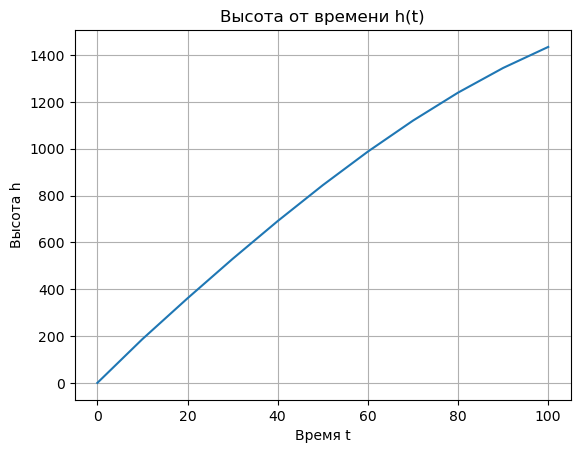

In [4069]:
# -------------------------------------------------------------------------------------
# Визуализация высоты от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t, z)
plt.xlabel('Время t')
plt.ylabel('Высота h')
plt.title('Высота от времени h(t)')
plt.grid(True)

plt.show()


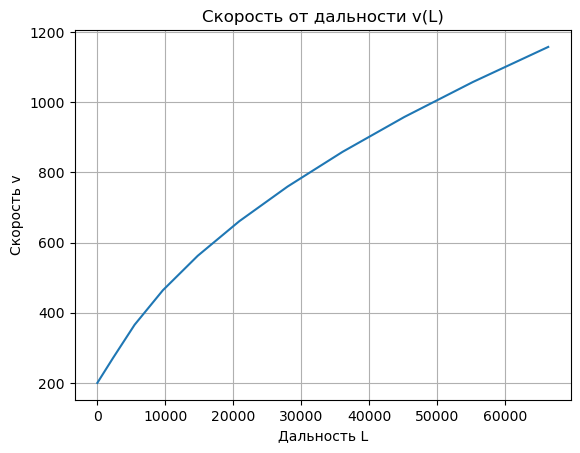

,t,vx,vy,vz,v,L
0,0,-80,-180,30,200,0
1,100,978,-619,-8,1157,66301


In [4070]:
# -------------------------------------------------------------------------------------
# Визуализация скорости от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L, v)
plt.xlabel('Дальность L')
plt.ylabel('Скорость v')
plt.title('Скорость от дальности v(L)')
plt.grid(True)

plt.show()

# -------------------------------------------------------------------------------------
# Таблица скорости от дальности
# -------------------------------------------------------------------------------------
data = pd.DataFrame()
data['t'] = t[0 : 100 : 10]
data['vx'] = list(map(int, vx[0 : 100 : 10]))
data['vy'] = list(map(int, vy[0 : 100 : 10]))
data['vz'] = list(map(int, vz[0 : 100 : 10]))
data['v'] = list(map(int, v[0 : 100 : 10]))
data['L'] = list(map(int, L[0 : 100 : 10]))
data

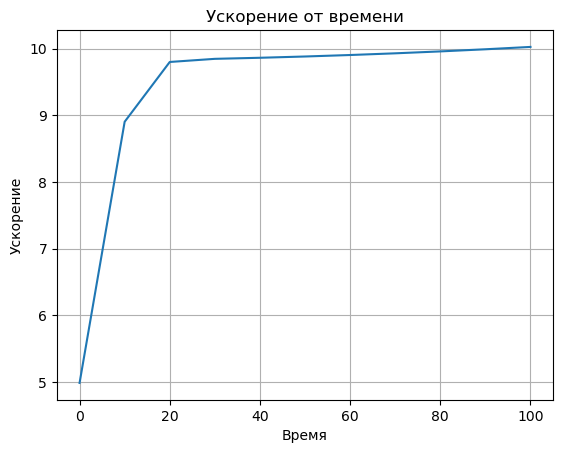

,g,L
0,4,0


In [4071]:
# -------------------------------------------------------------------------------------
# Нахождение ускорения: вычисленные координаты подставляю в систему уравнения: 
# dx/dt = x'
# dx'/dt = g
# -------------------------------------------------------------------------------------
state_g = get_result()
x_g = state_g[0]
y_g = state_g[1]
z_g = state_g[2]

vx_g = state_g[3]
vy_g = state_g[4]
vz_g = state_g[5]

v_g = np.sqrt(vx_g**2 + vy_g**2 + vz_g**2)
r_0 = np.sqrt(x_g**2 + y_g**2 + z_g**2)

A = GM/r_0**3
B = (3*c_0)/r_0**2
C = (15*c_0)/r_0**4
D = (6*c_0)/r_0**2

s = z_g/r_0                                     # синус широты цели
h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли

rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 
            + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
E = (-gamma * rho * v_g)/2

g_0x = -A*x_g + A*B*x_g - A*C*x_g*z_g**2
g_0y = -A*y_g + A*B*y_g - A*C*y_g*z_g**2
g_0z = -A*z_g + A*B*z_g + A*D*z_g - A*C*z_g**3

g_cax = omega**2 * x_g
g_cay = omega**2 * y_g

g_corx = 2 * omega * vy_g
g_cory = - 2 * omega * vx_g

g_aerx = E * vx_g
g_aery = E * vy_g
g_aerz = E * vz_g

g_x =  g_0x + g_cax + g_corx + g_aerx
g_y =  g_0y + g_cay + g_cory + g_aery
g_z =  g_0z + g_aerz
    
g = np.sqrt(g_x**2 + g_y**2 + g_z**2)
# -------------------------------------------------------------------------------------
# Таблица ускорение, время, дальность
# -------------------------------------------------------------------------------------
acceleration_x = pd.DataFrame()
acceleration_x['t'] = t[0 : 10000 : 100]

acceleration_x['g_0x'] =  g_0x[0 : 10000 : 100]
acceleration_x['g_cax'] = g_cax[0 : 10000 : 100]
acceleration_x['g_corx'] = g_corx[0 : 10000 : 100]
acceleration_x['g_aerx'] = g_aerx[0 : 10000 : 100]
acceleration_x['g_x'] = g_x[0 : 10000 : 100]
# -------------------------------------------------------------------------------------
acceleration_y = pd.DataFrame()
acceleration_y['t'] = t[0 : 10000 : 100]

acceleration_y['g_y'] = list(map(int, g_y[0 : 10000 : 100]))
# -------------------------------------------------------------------------------------
acceleration_z = pd.DataFrame()
acceleration_z['g_z'] = list(map(int, g_z[0 : 10000 : 100]))

# -------------------------------------------------------------------------------------
acceleration = pd.DataFrame()
acceleration['g'] = list(map(int, g[0 : 10000 : 100]))

acceleration['L'] = list(map(int, L[0 : 10000 : 100]))
# -------------------------------------------------------------------------------------
# Визуализация ускорения от времени
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(t, g)
plt.xlabel('Время')
plt.ylabel('Ускорение')
plt.title('Ускорение от времени')
plt.grid(True)

plt.show()
acceleration

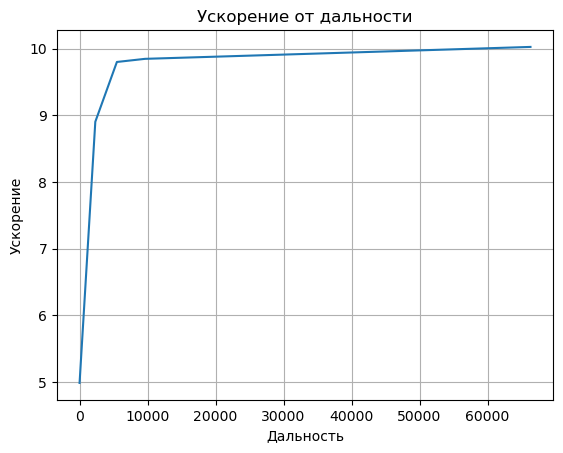

In [4072]:
# -------------------------------------------------------------------------------------
# Визуализация ускорения от дальности
# -------------------------------------------------------------------------------------
plt.figure()
plt.plot(L, g)
plt.xlabel('Дальность')
plt.ylabel('Ускорение')
plt.title('Ускорение от дальности')
plt.grid(True)

plt.show()

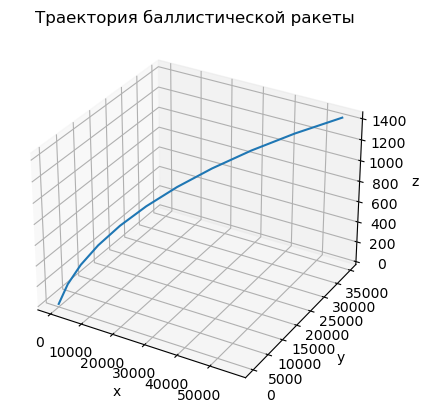

In [4073]:
# -------------------------------------------------------------------------------------
# Визуализация траектории ракеты в 3D
# -------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория баллистической ракеты')

plt.show()